In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import plotly.graph_objects as go
import re
from matplotlib.colors import LogNorm, Normalize
import numpy as np


In [2]:
training_curves = glob.glob('./results/*/*csv')
#training_curves2 = glob.glob('./results-MinMax-Schedule/*/*csv')

In [3]:
dfs = {}
res = {}
for curve in training_curves:#+training_curves2:
    name = curve.split('/')[2]
    f = pd.read_csv(curve).drop('epoch', axis = 1)
    f.index.name = 'epoch'
    dfs[name] = f.reset_index()
    res[name] = f.loc[f.val_loss.idxmin()].copy()
    #print(name ,f.val_loss.idxmin())
    res[name]['bst_epoch'] = f.val_loss.idxmin()
    res[name]['max_epoch'] = f.shape[0]
    res[name]['bst_epoch_lim'] = f[f.index <= 100_000].val_loss.idxmin()
    res[name]['loss_lim'] = f[f.index <= 100_000].loc[res[name]['bst_epoch_lim'], 'loss']
    res[name]['val_loss_lim'] = f[f.index <= 100_000].loc[res[name]['bst_epoch_lim'], 'val_loss']


In [4]:
df = pd.DataFrame(res).T.sort_values(by = 'val_loss')
df[['Features', 'Network']] = df.index.str.split('--').to_list()
df[['Type', 'Hops', 'Neis']] = df['Features'].str.split('-').tolist()
df['Neis'] = df['Neis'].str.extract(r'(\d+)').astype(int)
df['Hops'] = df['Hops'].str.extract(r'(\d+)').astype(int)
df.loc[df['Hops'] == 1, 'Hops'] = 0
df.loc[df['Hops'] == 0, 'Type'] = 'None'


In [5]:
pal = sns.color_palette('tab10')

In [6]:
df_bst = df.groupby(['Type', 'Hops', 'Neis'])[['val_loss', 'loss']].min().reset_index()

In [7]:
df['rmse'] = np.sqrt(df['loss'])#*0.8
df['val_rmse'] = np.sqrt(df['val_loss'])#*0.8

In [9]:
df_small = df.loc[df['Network'] == '16_32tanh'].copy()
df_arch = df.loc[(df['Features'] == 'paths-exp4-coords2') | (df['Features'] == 'paths-exp6-coords4')].sort_values(by = 'val_loss_lim').copy()

df_shape = pd.read_csv('shapes.csv', index_col= 0)
sahpes = df_shape.to_dict()['1']


df_small['Size'] = df_small.replace({"Features": sahpes})['Features'].values

params = {'paths-exp6-coords4--16_32_32tanh': 21_635,
'paths-exp6-coords4--16_32tanh': 20_579,
'paths-exp6-coords4--32_64tanh': 42_179,
'paths-exp6-coords4--64_128_128tanh': 104_963,
'paths-exp6-coords4--64_128tanh': 88_451,
'paths-exp6-coords4--8_16tanh': 10_163,
'paths-exp4-coords2--16_32_32tanh': 3_523,
'paths-exp4-coords2--16_32tanh': 2_467,
'paths-exp4-coords2--32_64tanh': 5_955,
'paths-exp4-coords2--64_128_128tanh': 32_515,
'paths-exp4-coords2--64_128tanh': 16_003,
'paths-exp4-coords2--8_16tanh': 1_107,}
df_arch['Parameters'] = df_arch.reset_index().replace({'index':params})['index'].values

In [11]:
df_small[['Hops', 'Neis', 'val_loss_lim']]

,Hops,Neis,val_loss_lim
paths-exp6-coords4--16_32tanh,6,4,0.008633
paths-exp4-coords4--16_32tanh,4,4,0.008521
paths-exp2-coords4--16_32tanh,2,4,0.008602
paths-exp4-coords2--16_32tanh,4,2,0.019671
cycles-exp2-coords4--16_32tanh,2,4,0.008883
cycles-exp8-coords4--16_32tanh,8,4,0.010015
paths-exp8-coords4--16_32tanh,8,4,0.012247
paths-exp6-coords3--16_32tanh,6,3,0.014779
cycles-exp1-coords4--16_32tanh,0,4,0.016585
paths-exp8-coords3--16_32tanh,8,3,0.017035


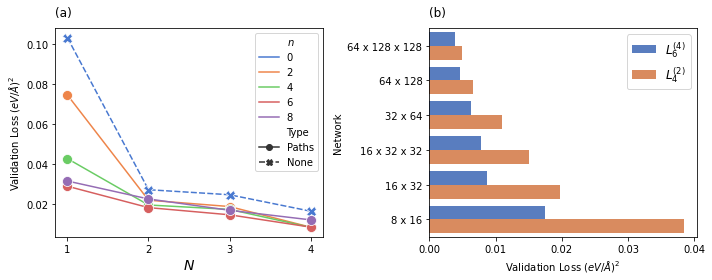

In [12]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

sns.lineplot(data = df_small[(df_small['Hops'] <= 8) & (df_small['Neis'] > 0) & ((df_small['Type'] == 'paths') |  (df_small['Type'] == 'None'))], x = 'Neis', y = 'val_loss_lim', hue = 'Hops', style = 'Type', palette= 'muted', markers=True, **{'markersize':10}, ax = ax[0])
#ax[0].set_ylim(top = 0.25)
ax[0].set_xticks([1, 2, 3, 4])
ax[0].set_ylabel(r'Validation Loss $(eV/Å)^2$')
ax[0].set_xlabel(r'$N$', fontdict={'size':14})
ax[0].get_legend().remove()
#ax[0].legend([x.capitalize() for x in ax[0].get_legend_handles_labels()[-1]])
handles, labels = ax[0].get_legend_handles_labels()
labels[0] = r'$n$'
labels[-2] = labels[-2].capitalize()
ax[0].legend(handles, labels, loc = 0)



sns.barplot(data = df_arch, x = 'val_loss_lim', y = 'Network', hue = 'Features', palette='muted')

handles, labels = ax[1].get_legend_handles_labels()
labels = [r'$L_{6}^{(4)}}$', r'$L_{4}^{(2)}}$']

ax[1].legend(handles, labels, loc = 0, fontsize = 12,)
ax[1].set_yticklabels([item.get_text().replace('tanh', '').replace('_', ' x ') for item in ax[1].get_yticklabels()])
ax[1].set_xlabel(r'Validation Loss $(eV/Å)^2$')
ax[0].set_title('(a)', loc = 'left', pad = 12)
ax[1].set_title('(b)', loc = 'left', pad = 12)

plt.tight_layout()
plt.savefig('figures/MO-benchmark.svg', bbox_inches='tight')
plt.savefig('figures/MO-benchmark.pdf', bbox_inches='tight')


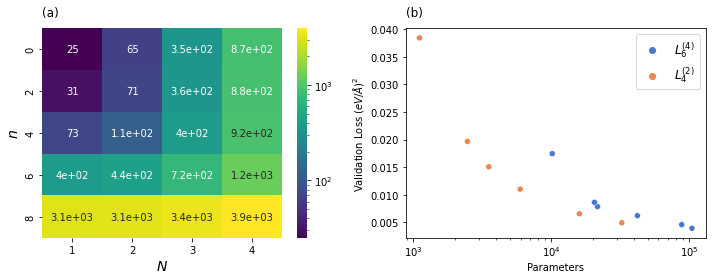

In [11]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

sns.heatmap(df_small[(df_small['Hops'] <= 8) & (df_small['Neis'] > 0) & ((df_small['Type'] == 'paths') |  (df_small['Type'] == 'None'))].pivot("Hops","Neis","Size"), annot=True, cmap = "viridis",  norm=LogNorm(), ax = ax[0])
ax[0].set_ylabel(r'$n$', fontdict={'size':14})
ax[0].set_xlabel(r'$N$', fontdict={'size':14})
ax[0].set_title('(a)', loc = 'left', pad = 12)


sns.scatterplot(data = df_arch, x = 'Parameters', y = 'val_loss_lim',  hue = 'Features', palette='muted')

ax[1].set_xscale('log')

handles, labels = ax[1].get_legend_handles_labels()
labels = [r'$L_{6}^{(4)}}$', r'$L_{4}^{(2)}}$']

ax[1].legend(handles, labels, loc = 0, fontsize = 12,)
ax[1].set_ylabel(r'Validation Loss $(eV/Å)^2$')
ax[1].set_title('(b)', loc = 'left', pad = 12)

plt.tight_layout()
plt.savefig('figures/MO-scalings.svg', bbox_inches='tight')
plt.savefig('figures/MO-scalings.pdf', bbox_inches='tight')


In [ ]:
df_small

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))

sns.lineplot(data = df_small[(df_small['Hops'] <= 8) & (df_small['Neis'] > 0) & ((df_small['Type'] == 'paths') |  (df_small['Type'] == 'None'))], x = 'Neis', y = 'val_loss_lim', hue = 'Hops', style = 'Type', palette= 'muted', markers=True, **{'markersize':10}, ax = ax[0])
#ax[0].set_ylim(top = 0.25)
ax[0].set_xticks([1, 2, 3, 4])
ax[0].set_ylabel(r'Validation Loss $(eV/Å)^2$')
ax[0].set_xlabel(r'$N$', fontdict={'size':14})
ax[0].get_legend().remove()
#ax[0].legend([x.capitalize() for x in ax[0].get_legend_handles_labels()[-1]])
handles, labels = ax[0].get_legend_handles_labels()
labels[0] = r'$n$'
labels[-2] = labels[-2].capitalize()
ax[0].legend(handles, labels, loc = 0)


df_tmp = df.loc[(df['Features'] == 'paths-exp4-coords2') | (df['Features'] == 'paths-exp6-coords4')].sort_values(by = 'val_loss_lim')

sns.barplot(data = df_tmp, x = 'val_loss_lim', y = 'Network', hue = 'Features', palette='muted')

handles, labels = ax[1].get_legend_handles_labels()
labels = [r'$L_{6}^{(4)}}$', r'$L_{4}^{(2)}}$']

ax[1].legend(handles, labels, loc = 0, fontsize = 12,)
ax[1].set_yticklabels([item.get_text().replace('tanh', '').replace('_', ' x ') for item in ax[1].get_yticklabels()])
ax[1].set_xlabel(r'Validation Loss $(eV/Å)^2$')
ax[0].set_title('(a)', loc = 'left', pad = 12)
ax[1].set_title('(b)', loc = 'left', pad = 12)

plt.tight_layout()
# plt.savefig('figures/MO-benchmark.svg', bbox_inches='tight')
# plt.savefig('figures/MO-benchmark.pdf', bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()

sns.lineplot(data = df_small[(df_small['Hops'] <= 8) & (df_small['Neis'] > 0) & ((df_small['Type'] == 'paths') |  (df_small['Type'] == 'None'))], x = 'Neis', y = 'val_loss_lim', hue = 'Hops', style = 'Type', palette= 'muted', markers=True, **{'markersize':10}, ax = ax)
#ax.set_ylim(top = 0.25)
ax.set_xticks([1, 2, 3, 4])
ax.set_ylabel(r'Validation Loss $(eV/Å)^2$')
ax.set_xlabel(r'$N$', fontdict={'size':14})
ax.get_legend().remove()
#ax.legend([x.capitalize() for x in ax.get_legend_handles_labels()[-1]])
handles, labels = ax.get_legend_handles_labels()
labels[0] = r'$n$'
labels[-2] = labels[-2].capitalize()
ax.legend(handles, labels, loc = 0)
#labels[6] = 'Multiplication'
#labels[1:6] = [str(x).split('.')[0] for x in labels[1:6]]
#plt.grid(axis='y')
plt.savefig('figures/MO-loss-neis.svg', bbox_inches='tight')
plt.savefig('figures/MO-loss-neis.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

df_tmp = df.loc[(df['Features'] == 'paths-exp4-coords2') | (df['Features'] == 'paths-exp6-coords4')].sort_values(by = 'val_loss_lim')

sns.barplot(data = df_tmp, x = 'val_loss_lim', y = 'Network', hue = 'Features')

handles, labels = ax.get_legend_handles_labels()
labels = [r'$n_{6}^{(4)}}$', r'$n_{4}^{(2)}}$']

ax.legend(handles, labels, loc = 0, fontsize = 12)
ax.set_yticklabels([item.get_text().replace('tanh', '').replace('_', ' x ') for item in ax.get_yticklabels()])
ax.set_xlabel(r'Validation Loss $(eV/Å)^2$')
plt.savefig('figures/MO-loss-network.pdf', bbox_inches='tight')
plt.savefig('figures/MO-loss-network.svg', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

sns.lineplot(data = df_small[(df_small['Hops'] <= 8) & (df_small['Neis'] >= 0) & ((df_small['Type'] == 'paths') |  (df_small['Type'] == 'None'))], x = 'Neis', y = 'val_loss_lim', hue = 'Hops', style = 'Type', palette= 'muted', markers=True, **{'markersize':10}, ax = ax)
#ax.set_ylim(top = 0.25)
ax.set_xticks([1, 2, 3, 4])
ax.set_ylabel(r'Validation Loss $(eV/Å)^2$')
ax.set_xlabel(r'$N$', fontdict={'size':14})
ax.get_legend().remove()
#ax.legend([x.capitalize() for x in ax.get_legend_handles_labels()[-1]])
handles, labels = ax.get_legend_handles_labels()
labels[0] = r'$n$'
labels[-2] = labels[-2].capitalize()
ax.legend(handles, labels, loc = 0)
#labels[6] = 'Multiplication'
#labels[1:6] = [str(x).split('.')[0] for x in labels[1:6]]
#plt.grid(axis='y')
plt.savefig('figures/MO-loss-neis2.svg', bbox_inches='tight')
plt.savefig('figures/MO-loss-neis2.pdf', bbox_inches='tight')

In [ ]:
df.loc[(df['Features'] == 'paths-exp4-coords2') | (df['Features'] == 'paths-exp6-coords4')].groupby(['Network', 'Features', 'Hops', 'Neis','Type'])[['loss', 'mae', 'val_loss', 'val_mae', 'rmse', 'val_rmse', 'loss_lim', 'val_loss_lim']].mean()

In [ ]:
sns.lineplot(data = df[(df['Hops'] < 10) & (df['Neis'] >= 0)], x = 'Neis', y = 'val_mae', hue = 'Hops', style = 'Type', palette= 'muted', markers=True, **{'markersize':10})
plt.ylim(top = 0.45)
plt.xticks([0, 1, 2, 3, 4])
plt.ylabel('MAE (eV/Å)')
plt.savefig('analysis-3-loss-neis.svg')

In [ ]:
k = 0
for i in  [0, 2, 4, 6, 8]:
    #sns.scatterplot(data = df_bst[(df_bst['Type'] == 'cycles') & (df_bst['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k])
    sns.lineplot(data = df_small[(df_small['Type'] == 'cycles') & (df_small['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k], marker='o', **{'markersize':10}, label = str(i))
    sns.lineplot(data = df_small[(df_small['Type'] == 'paths') & (df_small['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k], marker='s', **{'linestyle':'--', 'markersize':10}, alpha = 0.4, label = str(i))

#    sns.scatterplot(data = df_small[((df_small['Type'] == 'paths') | (df_small['Type'] == None)) & (df_small['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k])
#    sns.lineplot(data = df_small[((df_small['Type'] == 'paths') | (df_small['Type'] == None)) & (df_small['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k],  **{'linestyle':'--'})
    k = k + 1
plt.ylim(top = 0.2)

In [ ]:
k = 0
for i in  [0, 2, 4, 6, 8]:
    #sns.scatterplot(data = df_bst[(df_bst['Type'] == 'cycles') & (df_bst['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k])
    sns.lineplot(data = df_bst[(df_bst['Type'] == 'cycles') & (df_bst['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k], marker='o', **{'markersize':10}, label = str(i))
    sns.lineplot(data = df_bst[(df_bst['Type'] == 'paths') & (df_bst['Hops'] == i)], x = 'Neis', y = 'val_loss',  color = pal[k], marker='s', **{'linestyle':'--', 'markersize':10}, alpha = 0.4, label = str(i))

    k = k + 1
plt.ylim(top = 0.2)